In [40]:
from numpy.random import seed
seed(101)
tensorflow.random.set_seed(101)
from glob import glob
import pandas as pd
import numpy as np
import keras
from keras import backend as K
import seaborn as sns
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.listdir('../DL')

['.ipynb_checkpoints',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'model.h5',
 'skin lession detection-Copy1.ipynb',
 'skin lession detection-Copy2.ipynb',
 'skin lession detection.ipynb',
 'unet_100_epoch.h5']

#Create the directory structure
It has 7 different classes of skin diseases which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

In [3]:
base_dir = 'base_dir'
os.mkdir(base_dir)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [4]:
df_data = pd.read_csv('HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [38]:
test = pd.read_csv('hmnist_28_28_RGB.csv')

test.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
5,8,1,3,19,5,10,26,8,13,34,...,12,3,7,5,0,1,4,0,0,2
6,194,147,137,197,148,139,197,148,132,200,...,211,160,163,211,162,166,208,162,166,2
7,161,121,105,169,128,119,172,129,116,176,...,141,103,92,87,59,56,32,18,19,2
8,125,84,85,165,114,118,181,120,125,188,...,119,80,79,62,35,41,19,8,13,2
9,228,179,194,227,174,191,226,165,182,215,...,217,142,156,219,154,166,216,146,154,2


Text(0.5, 0.98, 'Univariate Distributions')

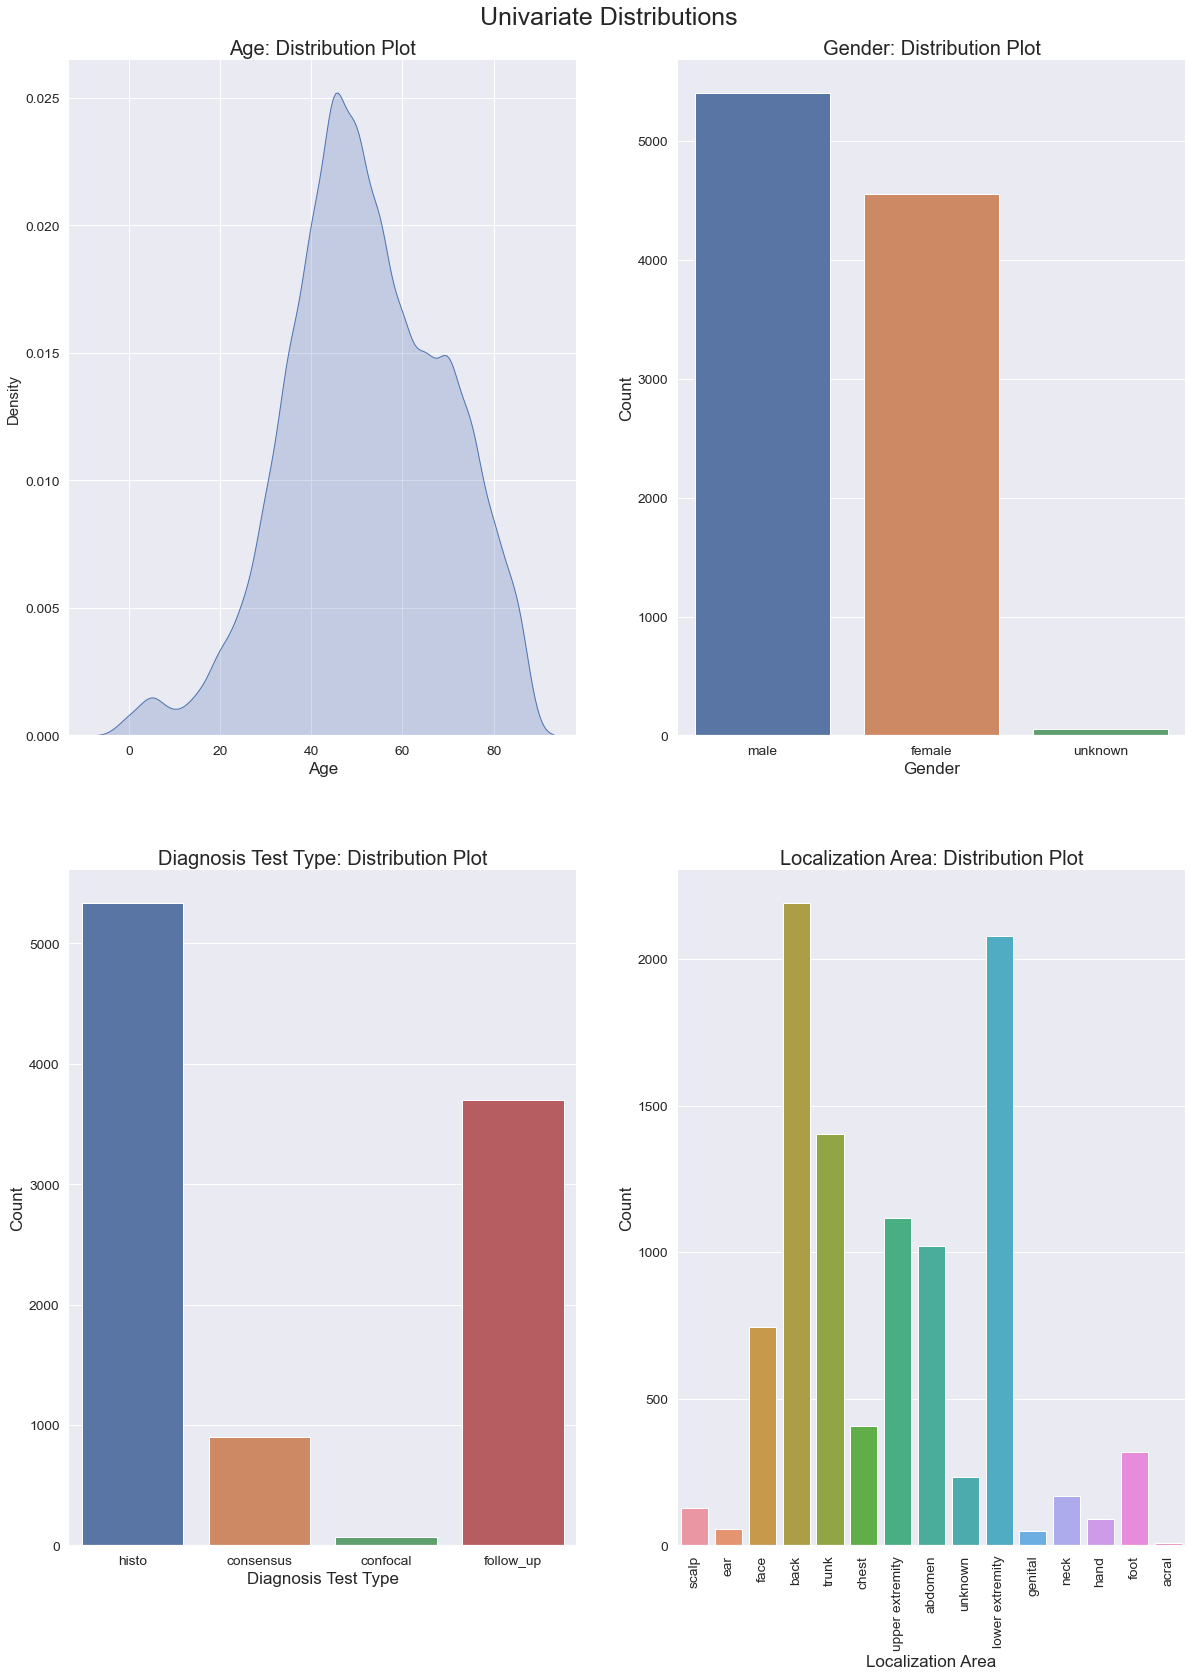

In [41]:
sns.set(font_scale = 1.25)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(20, 25))
sns.despine(left=True)

# Age distribution
sns.kdeplot(df_data["age"], legend = False, shade = True, ax=axes[0, 0])
axes[0,0].set_xlabel("Age", fontsize=17)
axes[0,0].set_title("Age: Distribution Plot", fontsize=20)

# Gender distribution
sns.countplot(x = "sex", data = df_data, ax=axes[0, 1])
axes[0,1].set_xlabel("Gender", fontsize=17)
axes[0,1].set_title("Gender: Distribution Plot", fontsize=20)
axes[0,1].set_ylabel("Count", fontsize=17)

# Diagnosis Test type distribution
sns.countplot(x = "dx_type", data = df_data, ax=axes[1, 0])
axes[1,0].set_xlabel("Diagnosis Test Type", fontsize=17)
axes[1,0].set_ylabel("Count", fontsize=17)
axes[1,0].set_title("Diagnosis Test Type: Distribution Plot", fontsize=20)

## Lesion type distribution
sns.countplot(x = "localization", data = df_data, ax=axes[1,1])
axes[1,1].set_xlabel("Localization Area", fontsize=17)
axes[1,1].set_ylabel("Count", fontsize=17)
axes[1,1].set_title("Localization Area: Distribution Plot", fontsize=20)

c = 0
for ax in f.axes:
    c+=1
    if c<=3:
        continue
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.subplots_adjust(top=0.95)
f.suptitle('Univariate Distributions', fontsize=25)

In [ ]:
#Create a stratified val set

In [5]:
df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [6]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

df_data['duplicates'] = df_data['lesion_id']

df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [7]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [8]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [9]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101)

df_val.shape

(938, 8)

In [10]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [11]:
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df_data['train_or_val'] = df_data['image_id']

df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   

df_train = df_data[df_data['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

9077
938


In [12]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [13]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

Transfer the Images into the Folders

In [14]:
df_data.set_index('image_id', inplace=True)

In [15]:
folder_1 = os.listdir('ham10000_images_part_1')
folder_2 = os.listdir('ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
      
        src = os.path.join('ham10000_images_part_1', fname)
       
        dst = os.path.join(train_dir, label, fname)
       
        shutil.copyfile(src, dst)

    if fname in folder_2:
       
        src = os.path.join('ham10000_images_part_2', fname)
       
        dst = os.path.join(train_dir, label, fname)
       
        shutil.copyfile(src, dst)
        
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
       
        src = os.path.join('ham10000_images_part_1', fname)
      
        dst = os.path.join(val_dir, label, fname)
       
        shutil.copyfile(src, dst)

    if fname in folder_2:
       
        src = os.path.join('ham10000_images_part_2', fname)
        
        dst = os.path.join(val_dir, label, fname)
       
        shutil.copyfile(src, dst)
        

In [16]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [17]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [19]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [20]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [21]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


Visualize 50 augmented images

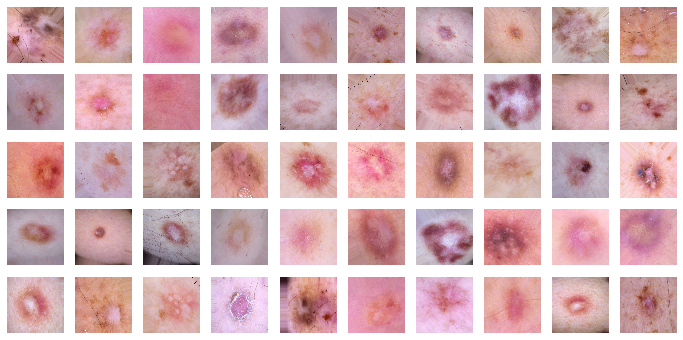

In [42]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
plots(imgs, titles=None)

Set Up the Generators

In [23]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [24]:
datagen = ImageDataGenerator(preprocessing_function= \ tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path, target_size=(image_size,image_size), batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path, target_size=(image_size,image_size), batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path, target_size=(image_size,image_size), batch_size=1, shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


Modify MobileNet Model

In [25]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [26]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [27]:
type(mobile.layers)

list

In [28]:
len(mobile.layers)

92

CREATE THE MODEL ARCHITECTURE

In [29]:
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

how many layers we actually want to be trained

In [31]:
for layer in model.layers[:-23]:
    layer.trainable = False

Train the Model

In [32]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [33]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [34]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [35]:
class_weights={
    0: 1.0, 
    1: 1.0, 
    2: 1.0, 
    3: 1.0,
    4: 3.0, 
    5: 1.0, 
    6: 1.0,
}

In [36]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, class_weight=class_weights, validation_data=valid_batches, validation_steps=val_steps, epochs=30, verbose=1)

C:\Users\pjpun\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
908/908 [==============================] - 609s 667ms/step - loss: 2.2004 - categorical_accuracy: 0.4535 - top_2_accuracy: 0.6510 - top_3_accuracy: 0.7879 - val_loss: 0.6862 - val_categorical_accuracy: 0.7655 - val_top_2_accuracy: 0.9083 - val_top_3_accuracy: 0.9627

Epoch 00001: val_top_3_accuracy improved from -inf to 0.96269, saving model to model.h5
Epoch 2/30
908/908 [==============================] - 581s 639ms/step - loss: 1.2624 - categorical_accuracy: 0.6142 - top_2_accuracy: 0.8161 - top_3_accuracy: 0.9139 - val_loss: 0.5095 - val_categorical_accuracy: 0.8284 - val_top_2_accuracy: 0.9254 - val_top_3_accuracy: 0.9723

Epoch 00002: val_top_3_accuracy improved from 0.96269 to 0.97228, saving model to model.h5
Epoch 3/30
908/908 [==============================] - 589s 649ms/step - loss: 1.1092 - categorical_accuracy: 0.6680 - top_2_accuracy: 0.8525 - top_3_accuracy: 0.9406 - val_loss: 0.5430 - val_categorical_accuracy: 0.8294 - val_top_2_accuracy: 0.9200 - val_top_3_ac

908/908 [==============================] - 619s 682ms/step - loss: 0.2111 - categorical_accuracy: 0.9385 - top_2_accuracy: 0.9896 - top_3_accuracy: 0.9992 - val_loss: 0.3672 - val_categorical_accuracy: 0.8987 - val_top_2_accuracy: 0.9627 - val_top_3_accuracy: 0.9893

Epoch 00023: val_top_3_accuracy did not improve from 0.98934
Epoch 24/30
908/908 [==============================] - 564s 621ms/step - loss: 0.2063 - categorical_accuracy: 0.9380 - top_2_accuracy: 0.9906 - top_3_accuracy: 0.9992 - val_loss: 0.3724 - val_categorical_accuracy: 0.8923 - val_top_2_accuracy: 0.9638 - val_top_3_accuracy: 0.9872

Epoch 00024: val_top_3_accuracy did not improve from 0.98934

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 25/30
908/908 [==============================] - 544s 599ms/step - loss: 0.2037 - categorical_accuracy: 0.9417 - top_2_accuracy: 0.9917 - top_3_accuracy: 0.9991 - val_loss: 0.3709 - val_categorical_accuracy: 0.8945 - val_top_2_accuracy: 0.962

Evaluate the model using the val set

In [43]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

last epoch

In [44]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \ model.evaluate_generator(test_batches,steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\pjpun\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.37040644884109497
val_cat_acc: 0.8965885043144226
val_top_2_acc: 0.9637526869773865
val_top_3_acc: 0.9893389940261841


best epoch

In [45]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \model.evaluate_generator(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.39127999544143677
val_cat_acc: 0.8795309066772461
val_top_2_acc: 0.9648187756538391
val_top_3_acc: 0.9893389940261841


Plot the Training Curves

<Figure size 432x288 with 0 Axes>

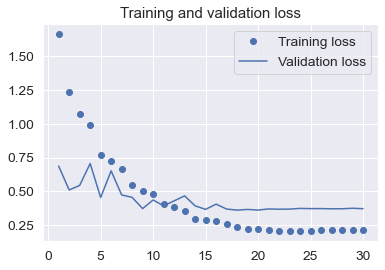

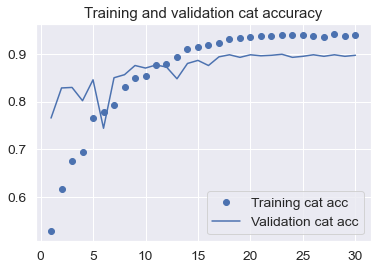

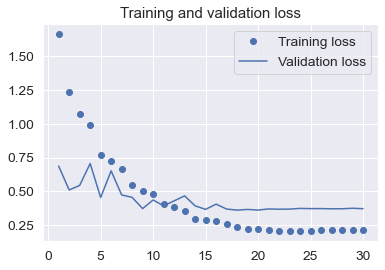

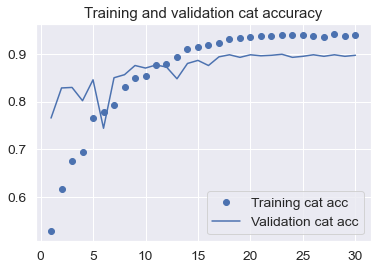

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

In [47]:
test_labels = test_batches.classes

In [48]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [49]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [50]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

C:\Users\pjpun\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


938/938 [==============================] - 46s 49ms/step


In [51]:
predictions.shape

(938, 7)

In [52]:
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [53]:
test_labels.shape

(938,)

In [54]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [55]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 10   4   6   0   4   2   0]
 [  1  21   5   0   3   0   0]
 [  2   0  37   0  18  18   0]
 [  0   0   0   4   0   2   0]
 [  0   1   2   1  28   7   0]
 [  1   2   4   1  26 715   2]
 [  0   0   0   0   0   1  10]]


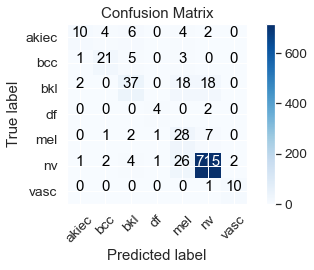

In [56]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Generate the Classification Report

In [57]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [58]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)d

              precision    recall  f1-score   support

       akiec       0.71      0.38      0.50        26
         bcc       0.75      0.70      0.72        30
         bkl       0.69      0.49      0.57        75
          df       0.67      0.67      0.67         6
         mel       0.35      0.72      0.47        39
          nv       0.96      0.95      0.96       751
        vasc       0.83      0.91      0.87        11

    accuracy                           0.88       938
   macro avg       0.71      0.69      0.68       938
weighted avg       0.90      0.88      0.88       938



In [ ]:
def plot_prediction(learn, index):
  data = learn.data.test_ds[index][0]
  pred = learn.predict(data)
  classes = learn.data.classes

  prediction = pd.DataFrame(to_np(pred[2]*100), columns=['Confidence'])
  prediction['Classes'] = classes
  prediction = prediction.sort_values(by='Confidence', ascending=False)

  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  show_image(data, figsize=(5, 5), ax=ax1)
  ax2 = fig.add_subplot(122)
  sns.set_color_codes("pastel")
  sns.barplot(x='Confidence', y='Classes', data=prediction,
              label="Total", color="b")
  ax2.set_title(f'Actual: {PurePath(learn.data.test_ds.items[index]).parts[5]}')

In [ ]:
plot_prediction(learn, np.random.choice(len(learn.data.test_ds)))